In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')
df.head()

Unnamed: 0                               uid  experimentVariant version  \
0           1  c4ca4238a0b923820dcc509a6f75849b                  1  v2.8.0   
1           2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0   
2           3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0   
3           4  a87ff679a2f3e71d9181a67b7542122c                  1  v2.8.0   
4           5  e4da3b7fbbce2345d7772b0674a318d5                  1  v2.8.0   

   purchase  
0         0  
1         0  
2         0  
3         0  
4         0

In [3]:
def aatest(first, second):
    simulations = 1000 # количество симуляций 
    n_s = 1000 #количество наблюдений в подвыборке
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = first.sample(n_s, replace = False).values 
        s2 = second.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    return (sum(np.array(res) <0.05) / simulations)

In [4]:
df.shape

(127018, 5)

In [5]:
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [6]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [7]:
#Группы для А/А теста

varient_1 = df[df.experimentVariant == 1]['purchase'] #первая группа
varient_0 = df[df.experimentVariant == 0]['purchase'] #вторая группа

## Запустите A/A-тест

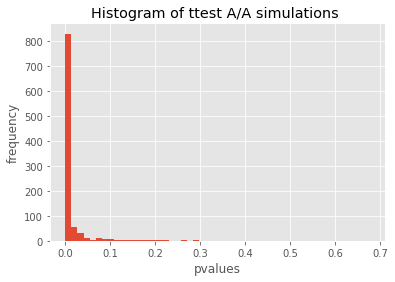

0.925

In [121]:
#Проведем А/А тест

aatest(varient_1, varient_0)

In [ ]:
#Тест показал FPR > уровня Альфа (0.05), значит в нашей сплит системе есть ошибка

## Поиск причин аномалии

In [8]:
#Сравним конверсию между версиями двух групп

table  = df.groupby(['experimentVariant', 'version'])\
    .agg({'purchase': 'sum', 'Unnamed: 0': 'count'})
table['convertion'] = round((table['purchase'] / table['Unnamed: 0'])*100, 2)
table['convertion']

experimentVariant  version 
0                  v2.8.0      0.10
                   v2.9.0      7.47
                   v3.7.4.0    5.99
                   v3.8.0.0    5.76
1                  v2.8.0      4.56
                   v2.9.0      7.13
                   v3.7.4.0    6.30
                   v3.8.0.0    6.28
Name: convertion, dtype: float64

In [126]:
# В версии v2.8.0 и v3.8.0.0 наблюдаются заметные отличия между первой и второй группой
# Необходимо провести сравнение между версиями двух групп, чтобы убедиться в их отличии 

## Найти pvalue для каждой версии МП

Версия 2.8.0

In [104]:
#Сравним версии v2.8.0 в двух группах

version_280_1 = df[(df.version == 'v2.8.0') & (df.experimentVariant == 1)]['purchase']
version_280_0 = df[(df.version == 'v2.8.0') & (df.experimentVariant == 0)]['purchase']

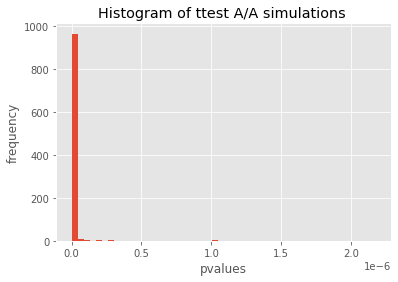

1.0

In [99]:
aatest(version_280_1, version_280_0)

In [127]:
#Тест показал статистически значимые отличия между двумя группами (FPR > уровня Альфа), значит данные версии не отличаются в двух группах

Версия 2.9.0

In [103]:
#Сравним версии v2.9.0 в двух группах

version_290_1 = df[(df.version == 'v2.9.0') & (df.experimentVariant == 1)]['purchase']
version_290_0 = df[(df.version == 'v2.9.0') & (df.experimentVariant == 0)]['purchase']

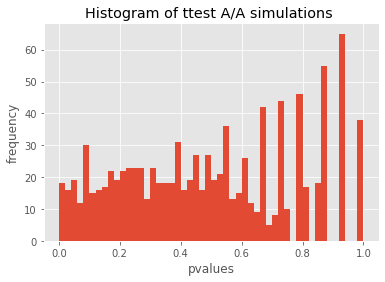

0.04

In [102]:
aatest(version_290_1, version_290_0)

In [ ]:
#Тест не показал статистически значимых отличий между двумя группами (FPR < уровня Альфа), значит данные версии не отличаются в двух группах

Версия 3.7.4.0

In [105]:
#Сравним версии v3.7.4.0 в двух группах

version_374_1 = df[(df.version == 'v3.7.4.0') & (df.experimentVariant == 1)]['purchase']
version_374_0 = df[(df.version == 'v3.7.4.0') & (df.experimentVariant == 0)]['purchase']

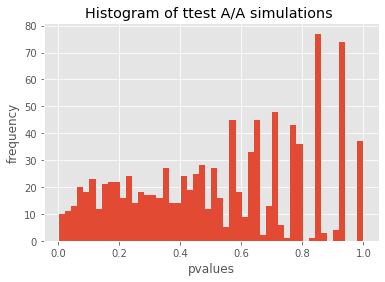

0.026

In [106]:
aatest(version_374_1, version_374_0)

In [ ]:
#Тест не показал статистически значимых отличий между двумя группами (FPR < уровня Альфа), значит данные версии не отличаются в двух группах

Версия 3.8.0.0

In [107]:
#Сравним версии v3.8.0.0 в двух группах

version_380_1 = df[(df.version == 'v3.8.0.0') & (df.experimentVariant == 1)]['purchase']
version_380_0 = df[(df.version == 'v3.8.0.0') & (df.experimentVariant == 0)]['purchase']

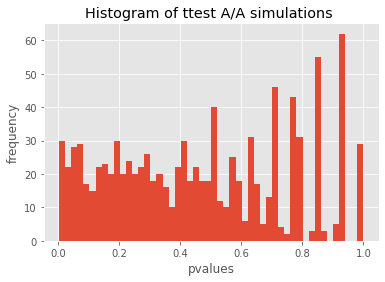

0.064

In [108]:
aatest(version_380_1, version_380_0)

In [ ]:
#Тест показал статистически значимые отличия между двумя группами (FPR > уровня Альфа), значит данные версии не отличаются в двух группах

## Повторное проведение А/А теста с оставшимися версиями

In [129]:
#Уберем из df версии с pvalue > уровня альфа

df = df.query('version != "v3.8.0.0" & version != "v2.8.0"')
df.head()

Unnamed: 0                               uid  experimentVariant version  \
1            2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0   
2            3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0   
6            7  8f14e45fceea167a5a36dedd4bea2543                  0  v2.9.0   
10          11  6512bd43d9caa6e02c990b0a82652dca                  1  v2.9.0   
13          14  aab3238922bcc25a6f606eb525ffdc56                  1  v2.9.0   

    purchase  
1          0  
2          0  
6          0  
10         0  
13         0

In [130]:
varient_1 = df[df.experimentVariant == 1]['purchase']
varient_0 = df[df.experimentVariant == 0]['purchase']

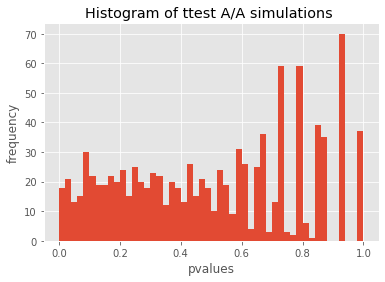

0.047

In [131]:
#Снова проведем тест

aatest(varient_1, varient_0)

In [ ]:
# FPR < уровня альфа

## Вывод

1) При проведении A/A теста была обнаружена ошибка в сплит системе (FPR > уровня альфа)
2) При проведении сравнения конверсий разных версий мобильного приложения между двумя группами были обнаружены значительные отклонения в версии v2.8.0 и v3.8.0.0
3) Проведение A/А теста между каждой из версий в двух группах подтвердило статистически значимые отличия (FPR > уровня альфа) между первой и второй группой в версии v2.8.0 и v3.8.0.0
5) После исключения данных версий из датафрейма и повторного проведения А/А теста, мы не получили статистически значимых отличий между двумя группами (FPR < уровня альфа). Значит данная часть датафрейма готова к проведению А/B тестов

Таким образом, высокий уровень FPR при проведении первого А/А теста был вызван ошибкой в версии v2.8.0 и v3.8.0.0. Чтобы точно разобраться в причинах данной ошибки, следует проверить корректно ли осуществляется сбор данных в этих версиях